# Stable Diffusion

**Generative AI** focuses on creating new content from data distributions, such as images, audio, or text. These models learn the underlying structure of a dataset and can generate realistic new samples that resemble the original data.

Earlier methods like Variational Autoencoders (VAEs) and Generative Adversarial Networks (GANs) were widely used for such tasks. While GANs are powerful in producing sharp images, they are known for training instability and mode collapse. VAEs, on the other hand, offer stability but often produce blurrier outputs due to their reliance on approximate likelihoods.

**Diffusion models** offer an alternative that combines stability with higher output quality. The key idea is simple:
  * Start with real data and gradually corrupt it with noise over time (the **forward process**).
  * Train a model to reverse this corruption — to turn pure noise back into meaningful data (the **reverse process**).

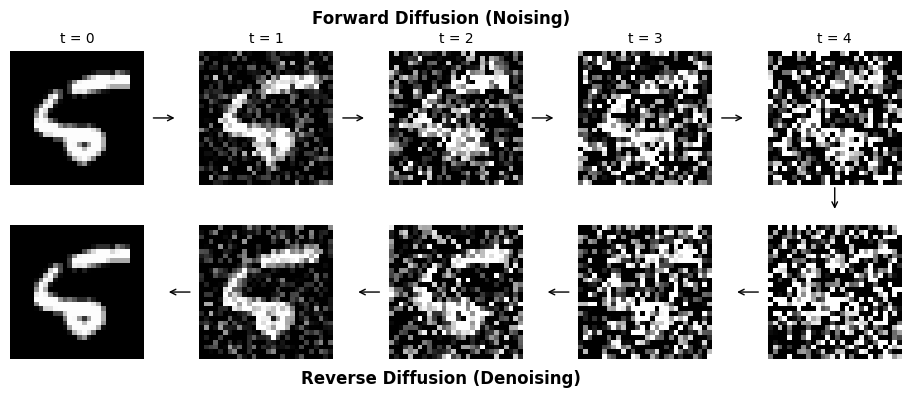

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms
from torchvision.datasets import MNIST

# Load a sample MNIST image
mnist = MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
img, _ = mnist[8]
img = img.squeeze(0)

# Define 5 noise levels
noise_levels = np.linspace(0.0, 1.0, 5)

# Apply noise to the same image twice (simulate forward and reverse)
forward_noised = [img + torch.randn_like(img) * level for level in noise_levels]
reverse_noised = [img + torch.randn_like(img) * level for level in noise_levels]

# Create a 2x5 grid of plots with larger images and tighter spacing
fig, axs = plt.subplots(2, 5, figsize=(12, 4))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

for i in range(5):
    axs[0, i].imshow(forward_noised[i].clamp(0, 1), cmap='gray')
    axs[0, i].axis('off')
    axs[0, i].set_title(f"t = {i}", fontsize=10)

    axs[1, i].imshow(reverse_noised[i].clamp(0, 1), cmap='gray')
    axs[1, i].axis('off')

axs[0, 0].set_ylabel("Forward", fontsize=12)
axs[1, 0].set_ylabel("Reverse", fontsize=12)

# Draw arrows (within Axes coordinates)
for i in range(4):
    axs[0, i].annotate('', xy=(1.25, 0.5), xycoords='axes fraction',
                      xytext=(1.05, 0.5), textcoords='axes fraction',
                      arrowprops=dict(facecolor='black', arrowstyle='->'))

    axs[1, i+1].annotate('', xy=(-0.25, 0.5), xycoords='axes fraction',
                         xytext=(-0.05, 0.5), textcoords='axes fraction',
                         arrowprops=dict(facecolor='black', arrowstyle='->'))

# Vertical arrow from last forward to last reverse
axs[0, 4].annotate('', xy=(0.5, -0.2), xycoords='axes fraction',
                   xytext=(0.5, 0.0), textcoords='axes fraction',
                   arrowprops=dict(facecolor='black', arrowstyle='->'))

# Annotation for rows
fig.text(0.5, 0.96, "Forward Diffusion (Noising)", ha='center', va='center', fontsize=12, weight='bold')
fig.text(0.5, 0.06, "Reverse Diffusion (Denoising)", ha='center', va='center', fontsize=12, weight='bold')

plt.show()

This gradual noising and denoising can be understood intuitively through the above diagram, where a signal is corrupted step-by-step, and then recovered in reverse. Here noising is a completely rule-based block with some inherent randomness of the noise. Denoising part is on the other hand can be done in several different ways and is the actual part that will be learned during training.

Unlike GANs, diffusion models optimize a well-defined likelihood objective and are typically easier to train. They also exhibit remarkable diversity and quality in their outputs, which makes them highly popular in state-of-the-art generative AI applications, including text-to-image models like DALL·E 2 and Stable Diffusion.

In the sections that follow, we explore the mathematical foundations and implementation details of these models using a simplified diffusion-based signal generation task.

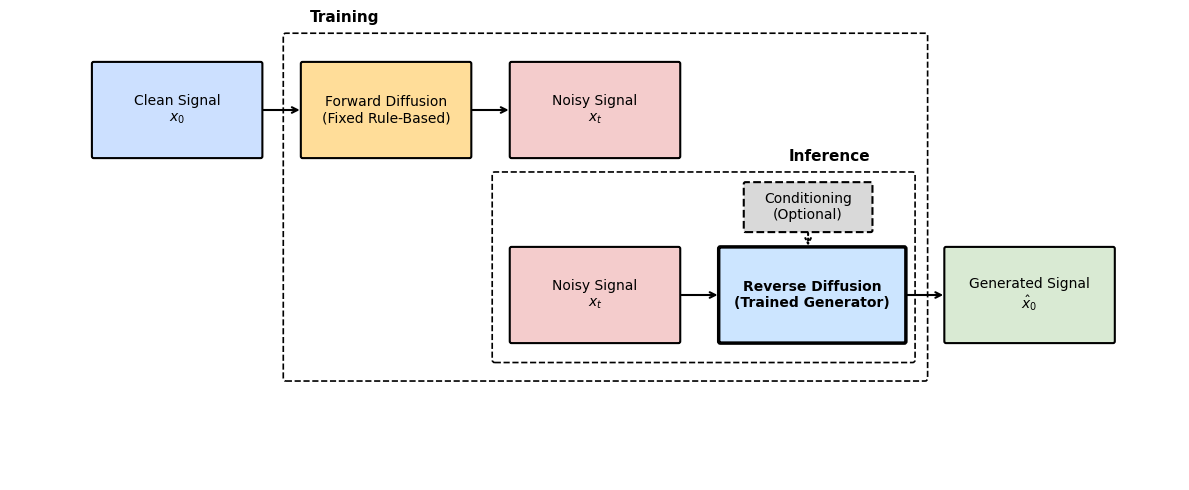

In [108]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 5))
ax.set_xlim(0, 14)
ax.set_ylim(0, 5)
ax.axis('off')

# Helper function to draw boxes with text
def draw_box(x, y, w, h, label, color, text_color='black', linewidth=1.5, dashed=False):
    linestyle = '--' if dashed else '-'
    box = patches.FancyBboxPatch((x, y), w, h, boxstyle="round,pad=0.02",
                                 linewidth=linewidth, edgecolor='black',
                                 facecolor=color, linestyle=linestyle)
    ax.add_patch(box)
    ax.text(x + w/2, y + h/2, label, ha='center', va='center',
            fontsize=10, color=text_color, weight='bold' if linewidth > 2 else 'normal')

# Draw nodes
draw_box(1, 3.5, 2, 1, "Clean Signal\n$x_0$", "#cce0ff")
draw_box(3.5, 3.5, 2, 1, "Forward Diffusion\n(Fixed Rule-Based)", "#ffdd99")
draw_box(6, 3.5, 2, 1, "Noisy Signal\n$x_t$", "#f4cccc")
draw_box(8.8, 2.7, 1.5, 0.5, "Conditioning\n(Optional)", "#d9d9d9", dashed=True)

draw_box(6, 1.5, 2, 1, "Noisy Signal\n$x_t$", "#f4cccc")
draw_box(8.5, 1.5, 2.2, 1, "Reverse Diffusion\n(Trained Generator)", "#cce5ff", linewidth=2.5)
draw_box(11.2, 1.5, 2, 1, "Generated Signal\n$\\hat{x}_0$", "#d9ead3")

# Arrows
def draw_arrow(x0, y0, x1, y1, **kwargs):
    ax.annotate('', xy=(x1, y1), xytext=(x0, y0), arrowprops=dict(arrowstyle="->", lw=1.5, **kwargs))

draw_arrow(3, 4, 3.5, 4)     # Clean -> Forward
draw_arrow(5.5, 4, 6, 4)     # Forward -> xt (train)
draw_arrow(9.55, 2.7, 9.55, 2.5, linestyle='dotted')  # Conditioning -> Reverse
draw_arrow(8, 2, 8.5, 2)     # xt -> Reverse
draw_arrow(10.7, 2, 11.2, 2) # Reverse -> Generated

# Draw dashed box around Training (excluding Clean Signal)
training_box = patches.FancyBboxPatch((3.3, 1.1), 7.65, 3.7,  # (x, y), width, height
    boxstyle="round,pad=0.03",edgecolor="black",
    facecolor="none", linestyle="--", linewidth=1.2)
ax.add_patch(training_box)
ax.text(4, 5.0, "Training", ha="center", va="center", fontsize=11, weight="bold")

# Draw dashed box around Inference (excluding Generated Signal)
inference_box = patches.FancyBboxPatch((5.8, 1.3), 5.0, 2.0,  # (x, y), width, height
    boxstyle="round,pad=0.03", edgecolor="black",
    facecolor="none", linestyle="--", linewidth=1.2)
ax.add_patch(inference_box)
ax.text(9.8, 3.5, "Inference", ha="center", va="center", fontsize=11, weight="bold")

plt.tight_layout()
plt.show()

The above diagram shows the general flow of the diffusion system. The overall structure of the diffusion process is split into two parts: **training** and **inference**.

  * **Training:** During training, a clean signal $x_0$ is progressively noised through a fixed, rule-based *forward diffusion* process to produce $x_t$, a noisy version of the signal at timestep $t$. This $x_t$, along with an optional conditioning input, which can be a one-hot vector to encode a particular class label or a text input describing a desired output, is then fed into the *reverse diffusion* model. The model is trained to denoise $x_t$ and predict the original signal $x_0$.
  
  * **Inference:** Once training is complete, we discard the forward path entirely. Inference begins with a noisy signal $x_t \sim \mathcal{N}(0, I)$ and iteratively applies the learned *reverse diffusion* model to generate a clean sample $\hat{x}_0$. The model can optionally condition on external data (e.g., class labels) in order to generate an output containing particular features.

  * **Key Insight:** The forward diffusion path is never learned — it is only used to prepare training inputs. The reverse diffusion path, however, is what constitutes the generative model and is the only component used during inference. In normal execution time, an arbitrary noise vector will be fed into it in order to get a more structured signal.

The next section demonstrates an implementation of a diffusion model to generate digit images using MNIST data where the denoiser will be a UNet-like structure with an encoder/decoder structure and skip connections between them.

## Implementation

In [1]:
import random
import numpy as np
import torch

def set_random_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [2]:
set_random_seed(0)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torch.utils.data import Subset

import numpy as np
import functools
import matplotlib.pyplot as plt
import math

import tqdm
from tqdm.notebook import trange, tqdm

from collections import defaultdict


def get_balanced_subset(dataset, samples_per_class=100):
    class_counts = defaultdict(int)
    indices = []

    for i, (_, label) in enumerate(dataset):
        if class_counts[label] < samples_per_class:
            indices.append(i)
            class_counts[label] += 1
        if sum(class_counts.values()) >= samples_per_class * 10:
            break

    return Subset(dataset, indices)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the MNIST dataset and create a data loader
mnist = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mnist_subset = get_balanced_subset(mnist, samples_per_class=500)
data_loader = torch.utils.data.DataLoader(mnist_subset, batch_size=64, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.33MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.65MB/s]


**Forward Diffusion Process**

In the diffusion framework, we start with a clean data sample $x_0$ (e.g., a digit image from MNIST) and gradually perturb it with Gaussian noise to produce a noisy sample $x_t$ at time $t$. This is defined as:

$$
x_t = x_0 + \sigma_t \cdot \epsilon, \quad \epsilon \sim \mathcal{N}(0, \mathbf{I})
$$

  * $x_0$ is the original clean signal.
  * $\epsilon$ is Gaussian noise sampled from a standard normal distribution.
  * $\sigma_t$ is a time-dependent noise scale function that increases with $t$.
  * As $t$ gets larger, the signal becomes nearly pure noise.

This process can be viewed probabilistically as:

$$
q(x_t \mid x_0) = \mathcal{N}(x_t \mid \alpha_t x_0, \sigma_t^2 \mathbf{I})
$$

**Noise Schedule Function**

In this implementation, the noise scale is defined using a continuous-time diffusion kernel:

$$
\sigma_t^2 = \frac{\sigma_0^{2t} - 1}{2 \log \sigma_0}
$$


  * $\sigma_0$ is a global hyperparameter and a constant.
  * The function defines how noise changes with $t$.
  * This schedule comes from a marginal variance kernel derived in continuous-time SDEs. In particular, the exponential diffusion $\sigma_0^{t}$.

**Reverse Diffusion Process**

The goal of reverse diffusion is to start from $x_T \sim \mathcal{N}(0, \mathbf{I})$ and recover a clean sample $x_0$ by denoising step-by-step using a trained model. This is done using the following discretization of the reverse-time stochastic differential equation (SDE):

$$
x_{t - \Delta t} = x_t + \left( \frac{\alpha_t^2}{\sigma_t^2} (\hat{x}_0 - x_t) \right) \cdot \Delta t + \sqrt{\Delta t} \cdot \alpha_t \cdot z, \quad z \sim \mathcal{N}(0, \mathbf{I})
$$

  * $ \hat{x}_0 $ is the model's prediction of the original clean signal (not the noise or score). This is estimated by the model that will be trained by us.
  * The deterministic term $ \frac{\alpha_t^2}{\sigma_t^2} (\hat{x}_0 - x_t) \cdot \Delta t $ gradually denoises $ x_t $ by pulling it toward the predicted clean signal.
  * The stochastic term $ \sqrt{\Delta t} \cdot \alpha_t \cdot z $ ensures diversity and smoothness during sampling.
  * Smaller values of $ \Delta t $ lead to finer reverse trajectories and more stable generation.

In [3]:
set_random_seed(0)

class DiffusionSchedule:
    def __init__(self, sigma_0=25):
        self.sigma_0 = sigma_0

    def sigma_t(self, t):
        return torch.sqrt((self.sigma_0 ** (2 * t) - 1) / (2 * np.log(self.sigma_0)))

    def marginal_prob_std(self, t):
        return self.sigma_t(t)[:, None, None, None]

    def diff_coeff(self, t):
        return (self.sigma_0 ** t)[:, None, None, None]

def forward_diffusion(x0, t, schedule):
    sigma_t = schedule.marginal_prob_std(t)
    epsilon = torch.randn_like(x0) # Noise from standard normal distribution
    x_t = x0 + sigma_t * epsilon
    return x_t, epsilon, sigma_t

@torch.no_grad()
def reverse_diffusion(model, schedule, x_init, y_onehot, steps=200):
    time_steps = torch.linspace(1., 1e-3, steps, device=x_init.device)
    step_size = time_steps[0] - time_steps[1]
    x = x_init.clone()

    for t in time_steps:
        t_batch = torch.ones(x.shape[0], device=x.device) * t
        coeff = schedule.diff_coeff(t_batch)
        x0_pred = model(x, t_batch, y=y_onehot)

        x_mean = x + (coeff ** 2) * (x0_pred - x) / (schedule.marginal_prob_std(t_batch) ** 2) * step_size
        x = x_mean + torch.sqrt(step_size) * coeff * torch.randn_like(x)

    return x_mean.clamp(0., 1.)

### UNet Architecture

In this implementation, the UNet acts as a **denoising autoencoder**, playing the critical role of predicting the clean signal $ \hat{x}_0 $ from a noisy input $ x_t $. While not the core innovation of diffusion models themselves, the UNet is a powerful backbone due to its encoder-decoder structure and extensive use of **skip connections**.

The encoder progressively downsamples the input, capturing multi-scale contextual features, while the decoder upsamples back to the original resolution. Skip connections bridge corresponding encoder and decoder levels, preserving spatial details that might otherwise be lost during downsampling. This architecture is particularly effective for denoising tasks.

The model also includes:

- **Time embedding** using sinusoidal encoding to inform the network about the noise level $ t $,
- An optional **label embedding** to enable conditional generation, concatenated with the time embedding before being injected into the decoding layers.

Though the UNet's role here is not unique to diffusion models, its structural advantages make it a natural choice for the reverse diffusion process.


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

set_random_seed(0)

class UNet(nn.Module):
    def __init__(self, channels=[16, 32, 64, 128], embed_dim=128, schedule=None):
        super().__init__()

        self.schedule = schedule
        self.activation = nn.ReLU()

        # Embedding layers
        self.time_mlp = nn.Sequential(
            self._build_sinusoidal_embedding(embed_dim),
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU()
        )

        self.label_mlp = nn.Linear(10, embed_dim)

        # Encoder blocks
        self.encoder = nn.ModuleList()
        self.encoder_time = nn.ModuleList()
        self.encoder_norm = nn.ModuleList()

        in_channels = 1
        for i, out_channels in enumerate(channels):
            self.encoder.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1 if i == 0 else 2, padding=1, bias=False))
            self.encoder_time.append(nn.Linear(embed_dim, out_channels))
            self.encoder_norm.append(nn.LayerNorm(out_channels))
            in_channels = out_channels

        # Decoder blocks
        self.decoder = nn.ModuleList()
        self.decoder_time = nn.ModuleList()
        self.decoder_norm = nn.ModuleList()

        for i in reversed(range(len(channels) - 1)):
            in_channels = channels[i + 1]
            out_channels = channels[i]
            self.decoder.append(nn.ConvTranspose2d(
                    in_channels * 2 if i != len(channels) - 2 else in_channels,
                    out_channels, kernel_size=3, stride=2, padding=1,
                    output_padding=1 if i != len(channels) - 2 else 0, bias=False)
            )
            self.decoder_time.append(nn.Linear(embed_dim, out_channels))
            self.decoder_norm.append(nn.LayerNorm(out_channels))

        # Final conv layer
        self.final_conv = nn.ConvTranspose2d(channels[0] * 2, 1, kernel_size=3, stride=1, padding=1)

        self._initialize_weights()

    def _build_sinusoidal_embedding(self, embed_dim, scale=30.):
        class _SinusoidalEmbedding(nn.Module):
            def __init__(self, W):
                super().__init__()
                self.W = W

            def forward(self, t):
                freqs = 2 * np.pi * t[:, None] * self.W[None, :]
                return torch.cat([torch.sin(freqs), torch.cos(freqs)], dim=-1)

        W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
        return _SinusoidalEmbedding(W)

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x, t, y=None):

        # Time embedding
        t_embed = self.activation(self.time_mlp(t))

        # Label embedding (optional)
        if y is not None:
            y_embed = self.label_mlp(y)
            t_embed = t_embed + y_embed

        # Encoding path
        features = []
        for conv, t_lin, norm in zip(self.encoder, self.encoder_time, self.encoder_norm):
            x = conv(x) + t_lin(t_embed)[:, :, None, None]
            x = self.activation(norm(x.permute(0, 2, 3, 1)).permute(0, 3, 1, 2))

            features.append(x)

        # Decoding path
        for i, (deconv, t_lin, norm) in enumerate(zip(self.decoder, self.decoder_time, self.decoder_norm)):
            skip = features[-(i + 1)]
            if skip.shape[2:] != x.shape[2:]:
                skip = F.interpolate(skip, size=x.shape[2:], mode='nearest')
            if i != 0:
                x = torch.cat([x, skip], dim=1)

            x = deconv(x) + t_lin(t_embed)[:, :, None, None]
            x = self.activation(norm(x.permute(0, 2, 3, 1)).permute(0, 3, 1, 2))

        x = torch.cat([x, features[0]], dim=1)
        x = self.final_conv(x)

        return x

### Training

**Training Objective and Practical Implementation**

In our implementation, the model is trained to predict the original clean signal $ x_0 $ directly from a noisy input $ x_t $. The loss is computed as the mean squared error between the predicted signal $ \hat{x}_0 $ and the ground truth:

$$
\mathcal{L}_{\text{MSE}} = \mathbb{E}_{x_0, t} \left[ \left\| \hat{x}_0 - x_0 \right\|^2 \right]
$$

  * $ \hat{x}_0 = f_\theta(x_t, t, y) $ is the model's prediction of the clean signal.
  * This simplifies training compared to score-matching and does not require rescaling by $ \sigma_t $.
  * The model is trained using pairs $ (x_t, y) $, where $ x_t $ is a noisy version of $ x_0 $, and $ y $ is a one-hot class label used for conditioning.

**Implementation Notes:**
  * For each sample in a batch, a single random time point $ t \sim \mathcal{U}(0, 1) $ is selected rather than iterating through a full diffusion trajectory.
  * Conditioning is applied by concatenating or injecting a one-hot vector representing the class label $ y $ into the model input. This will allow us to generate the particular class we want after training, otherwise it generates randomly any class from the training set (in our case digits).
  * This significantly reduces computational cost during training while still covering the full time horizon over many epochs.

In [5]:
set_random_seed(0)

def plot_generated(model, schedule, steps=200, samples_per_class=10, x_shape=(1, 28, 28)):
    num_classes = 10
    total_samples = num_classes * samples_per_class

    labels = torch.arange(num_classes).repeat_interleave(samples_per_class)
    y_onehot = F.one_hot(labels, num_classes=num_classes).float().to(device)

    t0_std = schedule.marginal_prob_std(torch.ones(total_samples, device=device))
    x_init = torch.randn(total_samples, *x_shape, device=device) * t0_std

    samples = reverse_diffusion(model, schedule, x_init, y_onehot, steps=steps)

    sample_grid = make_grid(samples, nrow=samples_per_class)
    plt.figure(figsize=(5, 5))
    plt.axis("off")
    plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
    plt.show()


Sampling at epoch 0/100


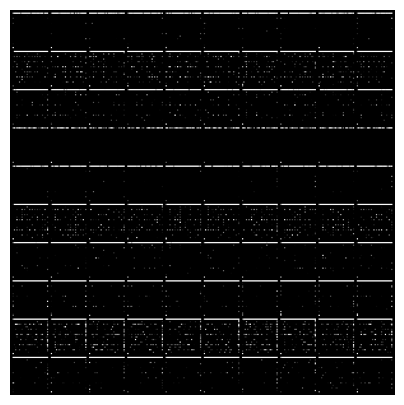

  0%|          | 0/100 [00:00<?, ?it/s]

Average Loss: 0.362716
Average Loss: 0.089148
Average Loss: 0.082367
Average Loss: 0.068515
Average Loss: 0.057606
Average Loss: 0.052248
Average Loss: 0.049140
Average Loss: 0.047446
Average Loss: 0.044928
Average Loss: 0.043522

Sampling at epoch 10/100


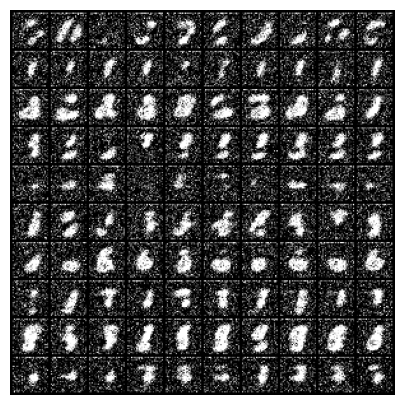

Average Loss: 0.042421
Average Loss: 0.040913
Average Loss: 0.040623
Average Loss: 0.040037
Average Loss: 0.039231
Average Loss: 0.039206
Average Loss: 0.038601
Average Loss: 0.037995
Average Loss: 0.038082
Average Loss: 0.037660

Sampling at epoch 20/100


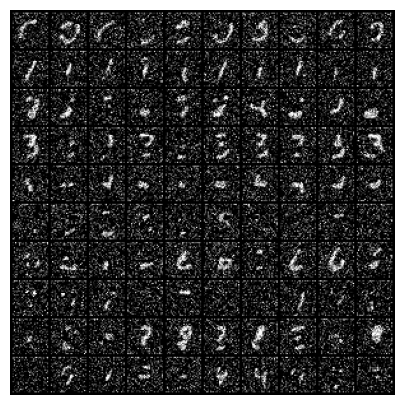

Average Loss: 0.037696
Average Loss: 0.037257
Average Loss: 0.037320
Average Loss: 0.037077
Average Loss: 0.036918
Average Loss: 0.036851
Average Loss: 0.037094
Average Loss: 0.036581
Average Loss: 0.036834
Average Loss: 0.036207

Sampling at epoch 30/100


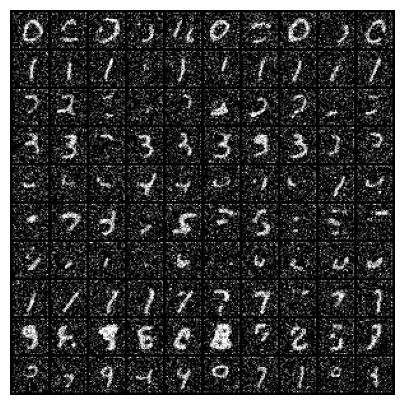

Average Loss: 0.035932
Average Loss: 0.036166
Average Loss: 0.036008
Average Loss: 0.035613
Average Loss: 0.035996
Average Loss: 0.035709
Average Loss: 0.035536
Average Loss: 0.035577
Average Loss: 0.035142
Average Loss: 0.035573

Sampling at epoch 40/100


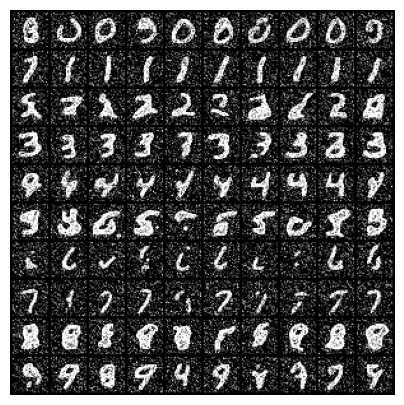

Average Loss: 0.035591
Average Loss: 0.035286
Average Loss: 0.035492
Average Loss: 0.035373
Average Loss: 0.035294
Average Loss: 0.035360
Average Loss: 0.034691
Average Loss: 0.034578
Average Loss: 0.034844
Average Loss: 0.034574

Sampling at epoch 50/100


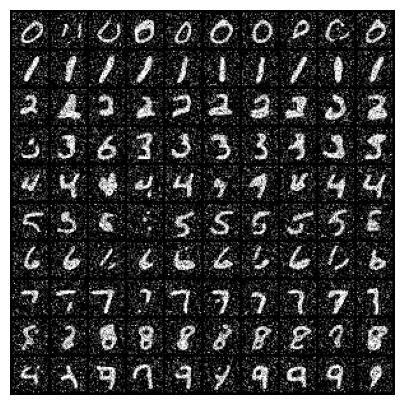

Average Loss: 0.034768
Average Loss: 0.034985
Average Loss: 0.034659
Average Loss: 0.035119
Average Loss: 0.034455
Average Loss: 0.034627
Average Loss: 0.034716
Average Loss: 0.034158
Average Loss: 0.034616
Average Loss: 0.034789

Sampling at epoch 60/100


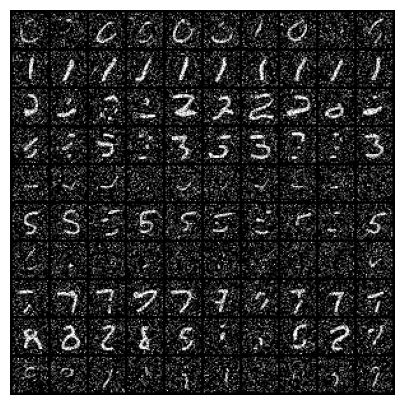

Average Loss: 0.034975
Average Loss: 0.034442
Average Loss: 0.034543
Average Loss: 0.034084
Average Loss: 0.034718
Average Loss: 0.033984
Average Loss: 0.034025
Average Loss: 0.034012
Average Loss: 0.034164
Average Loss: 0.034174

Sampling at epoch 70/100


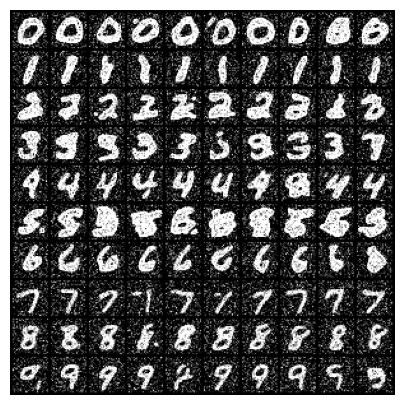

Average Loss: 0.034668
Average Loss: 0.034021
Average Loss: 0.034888
Average Loss: 0.034299
Average Loss: 0.034731
Average Loss: 0.033878
Average Loss: 0.034080
Average Loss: 0.034128
Average Loss: 0.033498
Average Loss: 0.034359

Sampling at epoch 80/100


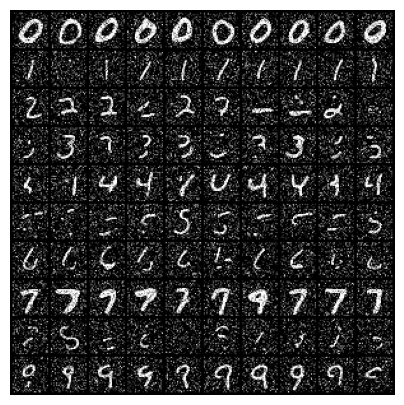

Average Loss: 0.034626
Average Loss: 0.033850
Average Loss: 0.034085
Average Loss: 0.034245
Average Loss: 0.034158
Average Loss: 0.033576
Average Loss: 0.033939
Average Loss: 0.034242
Average Loss: 0.034000
Average Loss: 0.034233

Sampling at epoch 90/100


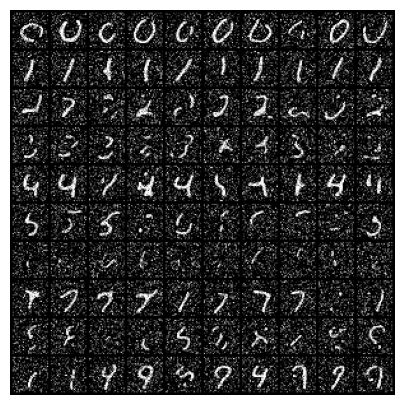

Average Loss: 0.033651
Average Loss: 0.034308
Average Loss: 0.033700
Average Loss: 0.033744
Average Loss: 0.033420
Average Loss: 0.033394
Average Loss: 0.034037
Average Loss: 0.033938
Average Loss: 0.033990
Average Loss: 0.033671

Sampling at epoch 100/100


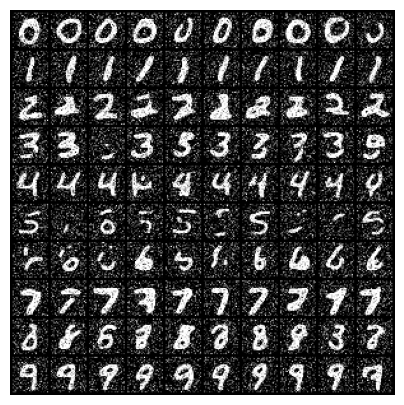

In [6]:
set_random_seed(0)

schedule = DiffusionSchedule(sigma_0=25)
model = UNet(schedule = schedule).to(device)

# Define the Adam optimizer for training the model
optimizer = Adam(model.parameters(), lr=1e-2)

n_epochs = 100

# Showing the untrained model output
print(f"\nSampling at epoch 0/{n_epochs}")
plot_generated(model, schedule, steps=200, x_shape=(1,28,28))

import torch.nn.functional as F

# Progress bar for epochs
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:

    total_loss = 0.; no_samples = 0
    for x, y in data_loader:

        batch_size = x.shape[0]
        no_samples += batch_size

        # y is a LongTensor
        y_onehot = F.one_hot(y, num_classes=10).float().to(device)

        # Forward diffusion function (fixed, no training here)
        t = torch.rand(batch_size, device=device)
        x_t, _, _ = forward_diffusion(x, t, schedule)

        # # Denoising UNet model
        x0_pred = model(x_t, t, y=y_onehot)
        # Loss with direct x0 prediction
        loss = F.mse_loss(x0_pred, x)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch_size

    # Print the averaged training loss for the current epoch
    print(f"Average Loss: {total_loss / no_samples:5f}")
    # Save the model checkpoint after each epoch of training
    torch.save(model.state_dict(), 'model_diffusion_denoiser.pth')

    # Sample and display every few epochs
    if (epoch + 1) % 10 == 0:
        print(f"\nSampling at epoch {epoch+1}/{n_epochs}")
        plot_generated(model, schedule, steps=200, x_shape=(1,28,28))

During training, we observe a consistent reduction in the denoising loss, indicating that the model is progressively learning to recover the clean signal from its noisy counterpart. Visually, the generated signals become increasingly coherent and sharp over time, with early epochs showing blurred or indistinct shapes, and later epochs producing well-defined digits.

The model is trained conditionally using class labels provided as one-hot vectors. This enables class-conditional generation, allowing us to control the identity of the generated digits. As training progresses, each row in the generated samples—corresponding to a fixed digit class—shows improved consistency and clearer digit formation.

Overall, the training demonstrates that the model successfully learns the reverse diffusion process, evolving from generating indistinct noise to producing clean, class-consistent digit samples.


During training, we observe a consistent reduction in the denoising loss, indicating that the model is progressively learning to recover the clean signal from its noisy counterpart. Visually, the generated signals become increasingly coherent and sharp over time, with early epochs showing blurred or indistinct shapes, and later epochs producing well-defined digits.

The model is trained conditionally using class labels provided as one-hot vectors. This enables class-conditional generation, allowing us to control the identity of the generated digit. As training progresses, each row in the generated samples—corresponding to a fixed digit class—shows improved consistency and clearer digit formation.

While the generation of certain digits—such as $5$ and $6$—remains somewhat less reliable compared to others, the overall structure of most digits is preserved well. These shortcomings could potentially be addressed with longer training or a more extensive dataset. Nevertheless, for demonstration purposes, the current results sufficiently showcase the success of the diffusion-based generative model and its conditional capabilities.


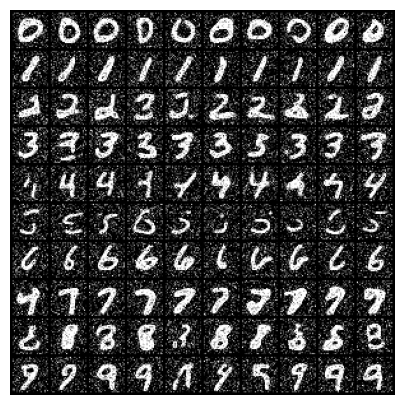

In [7]:
set_random_seed(0)
# Load the pre-trained model checkpoint
model_state = torch.load('model_diffusion_denoiser.pth', map_location=device)
model.load_state_dict(model_state)

plot_generated(model, schedule, steps=200)

### Interpolation in the Latent Space

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

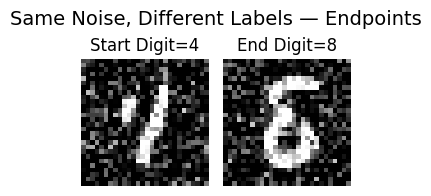

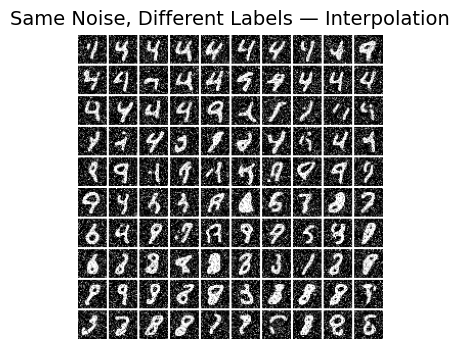

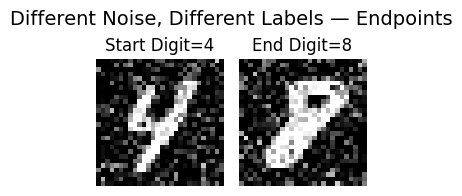

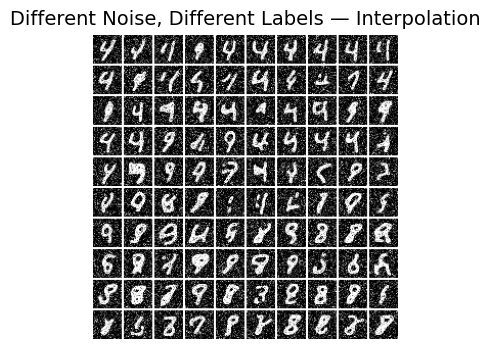

In [8]:
set_random_seed(0)

@torch.no_grad()
def interpolate_reverse_diffusion(model, schedule, z_start, z_end, y_start, y_end, steps=200, interp_steps=100):
    interpolated_images = []
    time_steps = torch.linspace(1., 1e-3, steps, device=device)

    for alpha in tqdm(torch.linspace(0., 1., interp_steps)):
        z = (1 - alpha) * z_start + alpha * z_end
        y = (1 - alpha) * y_start + alpha * y_end
        image = reverse_diffusion(model, schedule, z, y, steps)
        interpolated_images.append(image)

    return torch.cat(interpolated_images)

import matplotlib.pyplot as plt
from torchvision.utils import make_grid

def plot_interpolation_grid(interpolated_imgs, labels, title="Interpolation", nrow=10):
    # Normalize full tensor to [0, 1] just in case
    imgs = (interpolated_imgs + 1) / 2
    imgs = imgs.clamp(0.0, 1.0)

    img_start = imgs[0]
    img_end = imgs[-1]

    # --- Plot Start and End images ---
    fig, axs = plt.subplots(1, 2, figsize=(3, 2))  # width x height
    axs[0].imshow(img_start.squeeze().cpu(), cmap='gray')
    axs[0].axis("off")
    axs[0].set_title(f"Start Digit={labels[0]}", fontsize=12)

    axs[1].imshow(img_end.squeeze().cpu(), cmap='gray')
    axs[1].axis("off")
    axs[1].set_title(f"End Digit={labels[1]}", fontsize=12)

    plt.suptitle(f"{title} — Endpoints", fontsize=14)
    plt.tight_layout()
    plt.show()

    # --- Plot Interpolated Grid ---
    grid = make_grid(imgs, nrow=nrow, normalize=True, pad_value=1)
    plt.figure(figsize=(nrow, 4))  # Adjust width to match number of cols
    plt.axis("off")
    plt.title(f"{title} — Interpolation", fontsize=14)
    plt.imshow(grid.permute(1, 2, 0).cpu(), cmap='gray', vmin=0.0, vmax=1.0)
    plt.show()

# Load the pre-trained model checkpoint
model_state = torch.load('model_diffusion_denoiser.pth', map_location=device)
model.load_state_dict(model_state)

# Create start/end noise and labels
z1 = torch.randn(1, 1, 28, 28, device=device)
z2 = torch.randn(1, 1, 28, 28, device=device)
label1 = 4; label2 = 8;
y1 = F.one_hot(torch.tensor([label1]), num_classes=10).float().to(device)
y2 = F.one_hot(torch.tensor([label2]), num_classes=10).float().to(device)

# Run interpolations
imgs_same = interpolate_reverse_diffusion(model, schedule, z1, z1, y1, y2, interp_steps=100)
imgs_diff = interpolate_reverse_diffusion(model, schedule, z1, z2, y1, y2, interp_steps=100)

plot_interpolation_grid(imgs_same, [label1, label2], "Same Noise, Different Labels")
plot_interpolation_grid(imgs_diff, [label1, label2], "Different Noise, Different Labels")

To further evaluate the behavior of the trained diffusion model, we perform interpolation between two digit classes. The process involves fixing either the noise vector or both the noise and the labels, and linearly interpolating between the one-hot label embeddings.

Two scenarios are explored:

  * **Same Noise, Different Labels:** The initial noise $z$ is kept fixed, and the label is gradually interpolated from class 4 to class 8. This setting demonstrates how the model smoothly morphs one digit into another under identical stochastic input. Although the digits change class, the overall "style" or "texture" remains similar, reflecting the shared noise foundation.
  
  * **Different Noise, Different Labels:** Both the noise vector and labels are sampled independently at the endpoints and interpolated. This simulates a more realistic variation in both structure and class. The generated digits change more dramatically across the sequence, displaying both structural and semantic shifts.

These results illustrate that as the input noise and/or labels are gradually interpolated, the outputs exhibit corresponding smooth transitions. This confirms that the model has learned a meaningful latent space in which semantic transformations are continuous and controllable. For instance, such behavior can be highly valuable in medical imaging, where smoothly interpolating between different stages of a condition can help visualize disease progression, or in weather map synthesis, where gradual transitions can simulate changing atmospheric conditions. These examples demonstrate the broader applicability of diffusion models in generating coherent and interpretable intermediate states.